# Data Sampling and Frame Extraction

#### *Bayesian ML: Katy Koo, Kevin Sianto, Samuel Martinez Koss, Veera Anand*

\

Repository:

https://github.com/koobcbc/Bayesian_heart_rate_prediction

\

References:

https://echonet.github.io/dynamic/index.html

https://github.com/echonet/dynamic?tab=readme-ov-file

https://www.nature.com/articles/s41586-020-2145-8

## Setup

Import basic libraries and standardize directory access.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.4f}'.format

base_dir = '.../dynamic'
video_dir = os.path.join(base_dir, 'a4c-video-dir/Videos')

os.chdir(base_dir)
!pwd

In order to run EchoNet-Dynamic, additional directories must be loaded and the model must be set up and imported.

    \#!git clone https://github.com/echonet/dynamic.git

    \#!cd dynamic

    \#%pip install --user .

## Loading

Load echocardiogram video names, metadata, and heart health metrics.

In [ ]:
filelist_path = os.path.join(base_dir, 'a4c-video-dir/FileList.csv')
echo_files = pd.read_csv(filelist_path)
echo_files.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.4984,14.8814,69.2105,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.1020,40.3839,98.7429,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.3638,14.2678,37.9097,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.5451,33.1431,72.9142,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.8877,127.5819,169.8550,112,112,52,207,VAL


Load manually constructed volume tracings for frames of each video.

In [ ]:
tracings_path = os.path.join(base_dir, 'a4c-video-dir/VolumeTracings.csv')
echo_tracings = pd.read_csv(tracings_path)
echo_tracings.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.2604,15.3490,64.9323,69.1250,46
1,0X100009310A3BD7FC.avi,50.0376,17.1678,53.3672,16.3213,46
2,0X100009310A3BD7FC.avi,49.1574,20.4076,57.0905,18.3907,46
3,0X100009310A3BD7FC.avi,48.5382,23.5811,59.9973,20.6677,46
4,0X100009310A3BD7FC.avi,47.9190,26.7545,62.9041,22.9447,46


Check whether each echocardiogram can be accessed by this notebook.

In [ ]:
expected_files = [filename + '.avi' for filename in echo_files['FileName']]
video_file_list = os.listdir(video_dir)

if set(expected_files).issubset(video_file_list):
    print("All video files present.")
else:
    print(f"{10031 - len(video_file_list)} video files missing.")

All video files present.


## Sampling

Subset the videos based on highest common occurances of metadata attributes.

In [ ]:
most_common = {
    'FrameHeight': echo_files['FrameHeight'].value_counts().idxmax(),
    'FrameWidth': echo_files['FrameWidth'].value_counts().idxmax(),
    'FPS': echo_files['FPS'].value_counts().idxmax(),
    'NumberOfFrames': echo_files['NumberOfFrames'].value_counts().idxmax()
}

common_vids = echo_files[
    (echo_files['FrameHeight'] == most_common['FrameHeight']) &
    (echo_files['FrameWidth'] == most_common['FrameWidth']) &
    (echo_files['FPS'] == most_common['FPS']) &
    (echo_files['NumberOfFrames'] == most_common['NumberOfFrames'])
].copy()

c_vids_files = [filename + '.avi' for filename in common_vids['FileName']]
c_vids_paths = [os.path.join(video_dir, filename) for filename in c_vids_files]
common_vids['FilePath'] = c_vids_paths
print("Subset Split Labels:", common_vids['Split'].value_counts(), "\n")
common_vids.head()

Subset Split Labels: Split
TRAIN    164
VAL       24
TEST      20
Name: count, dtype: int64 



,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split,FilePath
10,0X1012703CDC1436FE,41.0144,71.3791,121.0112,112,112,50,201,TEST,deidentified/file/path/0X1012703CDC1436FE.avi
38,0X1059077339EF0869,66.1994,21.1534,62.5828,112,112,50,201,TRAIN,deidentified/file/path/0X1059077339EF0869.avi
191,0X1227CDDF6A114129,76.1430,17.0392,71.4222,112,112,50,201,TRAIN,deidentified/file/path/0X1227CDDF6A114129.avi
378,0X14BFDFE46468D601,45.4099,54.6171,100.0495,112,112,50,201,TRAIN,deidentified/file/path/0X14BFDFE46468D601.avi
501,0X166087A5E749713A,34.6505,31.6181,48.3831,112,112,50,201,TRAIN,deidentified/file/path/0X166087A5E749713A.avi


Optionally generate random splits for hold-out validation within the split labels from the construction of EchoNet-Dynamic.

In [ ]:
common_vids_train = common_vids.loc[common_vids['Split'] == 'TRAIN']
TrainList = common_vids_train.sample(n=80, random_state=32014)
train_files = [filename + '.avi' for filename in TrainList['FileName']]
train_paths = [os.path.join(video_dir, filename) for filename in train_files]
TrainList['FilePath'] = train_paths

common_vids_test = common_vids.loc[common_vids['Split'] != 'TRAIN']
TestList = common_vids_test.sample(n=20, random_state=32014)
test_files = [filename + '.avi' for filename in TestList['FileName']]
test_paths = [os.path.join(video_dir, filename) for filename in test_files]
TestList['FilePath'] = test_paths

RelevantFiles = pd.concat([TrainList, TestList], ignore_index=True)
print("Sampled Split Labels:", RelevantFiles['Split'].value_counts(), "\n")
RelevantFiles.head()

Sampled Split Labels: Split
TRAIN    80
VAL      10
TEST     10
Name: count, dtype: int64 



,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split,FilePath
0,0X4F331FB817B1F3BE,66.3875,28.1261,83.6776,112,112,50,201,TRAIN,deidentified/file/path/0X4F331FB817B1F3BE.avi
1,0X8C4EE7B7BDD0AE9,57.4626,24.6324,57.9077,112,112,50,201,TRAIN,deidentified/file/path/0X8C4EE7B7BDD0AE9.avi
2,0X20FAB502219482F3,61.6599,41.8573,109.1738,112,112,50,201,TRAIN,deidentified/file/path/0X20FAB502219482F3.avi
3,0X306F42A51FFEB3CD,56.7694,25.4201,58.8011,112,112,50,201,TRAIN,deidentified/file/path/0X306F42A51FFEB3CD.avi
4,0X60F0EBEA2ECCA7,59.6961,38.8865,96.4833,112,112,50,201,TRAIN,deidentified/file/path/0X60F0EBEA2ECCA7.avi


## Frame Extraction

Helper function to extract frames from echocardiogram videos.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [3, 0, 4, ..., 0, 0, 0],
       [0, 0, 3, ..., 2, 2, 3]], dtype=uint8)
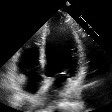

In [ ]:
import cv2

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()
    return np.array(frames)

extract_frames(os.path.join(video_dir, "0X1A193199E812B948.avi"))[0]

Loop through common videos subset and extract frames.

In [ ]:
extracted_videos = {}
for i in np.arange(len(common_vids)):
    row = common_vids.iloc[[i]]
    name = row['FileName'].values[0]
    path = row['FilePath'].values[0]

    print(f"Extracting frames from {name}...")
    frames = extract_frames(path)
    extracted_videos[name] = frames

print("Frame extraction complete.")

Extracting frames from 0X1012703CDC1436FE...
Extracting frames from 0X1059077339EF0869...
Extracting frames from 0X1227CDDF6A114129...
Extracting frames from 0X14BFDFE46468D601...
Extracting frames from 0X166087A5E749713A...
Extracting frames from 0X176C1E76AD804467...
Extracting frames from 0X18CE4A36AE88A585...
Extracting frames from 0X1904DC1BFE26592F...
Extracting frames from 0X19BDD7CE32887463...
Extracting frames from 0X19DF9461CA5F498F...
Extracting frames from 0X1A2A76BDB5B98BED...
Extracting frames from 0X1AB987597AF39E3B...
Extracting frames from 0X1AE66E51AC2B077C...
Extracting frames from 0X1BA556585D2FE6A7...
Extracting frames from 0X1BB609E66AC34DE...
Extracting frames from 0X1BF00F2E669B915E...
Extracting frames from 0X1C4BA7E6CC226887...
Extracting frames from 0X1C7A7B6A9AF3D511...
Extracting frames from 0X1C9F9EC57DDAFE0B...
Extracting frames from 0X1D5D36D11FB698E6...
Extracting frames from 0X1D97238D22053D7F...
Extracting frames from 0X1DD7E4C84703951C...
Extracting 

Pickle extracted frames.

In [ ]:
df_videos = pd.DataFrame({"Video_Name": list(extracted_videos.keys()),
                          "Frames": list(extracted_videos.values())})
pickle_path = os.path.join(base_dir, "a4c-video-dir/extracted_frames.pkl")
df_videos.to_pickle(pickle_path)

Check to ensure properly saved.

In [ ]:
df_videos = pd.read_pickle(pickle_path)
print(df_videos.head())

           Video_Name                                             Frames
0  0X1012703CDC1436FE  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
1  0X1059077339EF0869  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
2  0X1227CDDF6A114129  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
3  0X14BFDFE46468D601  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
4  0X166087A5E749713A  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...


## Next Steps

Copy of basic loading code needed to access extracted frames in **2. Feature Extraction and HMM Creation.ipynb**.

In [ ]:
import os
import pandas as pd

base_dir = '.../dynamic'

pickle_path = os.path.join(base_dir, "a4c-video-dir/extracted_frames.pkl")
df_videos = pd.read_pickle(pickle_path)
print(df_videos.head())

## Appendix

Alternate code shows how to extract frames and save them as individual .png files. **Not recommended** due to loading time.

In [ ]:
output_root = os.path.join(base_dir, 'a4c-video-dir/extracted_frames')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [3, 0, 4, ..., 0, 0, 0],
       [0, 0, 3, ..., 2, 2, 3]], dtype=uint8)
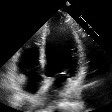

In [ ]:
import cv2
extract_frames_check = os.path.join(output_root, 'check')

def extract_frames_png(video_path, frames_dir=extract_frames_check):
    cap = cv2.VideoCapture(video_path)
    frames = []
    f_index = 0
    os.makedirs(frames_dir, exist_ok=True)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

        frame_filename = os.path.join(frames_dir, f"frame_{f_index:04d}.png")
        cv2.imwrite(frame_filename, gray_frame)
        f_index += 1

    cap.release()
    return np.array(frames)

check = extract_frames_png(os.path.join(video_dir, '0X1A193199E812B948.avi'))

if 1:
    import shutil
    shutil.rmtree(extract_frames_check)

check[0]

In [ ]:
png_demo = RelevantFiles.iloc[[0]]

for i in np.arange(len(png_demo)):
    row = png_demo.iloc[[i]]
    name = row['FileName'].values[0]
    path = row['FilePath'].values[0]

    print(f"Extracting frames from {name}...")
    output_dir = os.path.join(output_root, name)
    extract_frames_png(path, output_dir)

print("Frame extraction complete.")

Extracting frames from 0X4F331FB817B1F3BE...
Frame extraction complete.
